#### Kaggle: https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python

# Regression

# Introduction

## Import Data & Packages

In [1]:
import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

import os

import warnings
warnings.simplefilter(action='ignore')

In [2]:
os.listdir("../Kaggle_Titanic_Regression/Input")

['gender_submission.csv', 'test.csv', 'train.csv']

In [3]:
train = pd.read_csv("../Kaggle_Titanic_Regression/Input/train.csv")
test = pd.read_csv("../Kaggle_Titanic_Regression/Input/test.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
len(train), len(test)

(891, 418)

## Data Quality and Missing Value Assessment

In [5]:
# Missing Value 존재 : Age, Cabin, Emarked
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Missing Value 관리
**1. Age**

In [6]:
# Age Missing Value 비율
train['Age'].isnull().sum()/len(train)*100

19.865319865319865

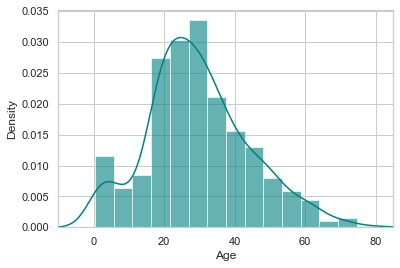

In [7]:
# Age에 대한 자료를 히스토그램으로 표현
ax = train["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train["Age"].plot(kind='density', color='teal')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

In [8]:
# 평균, 중앙값
train["Age"].mean(skipna=True), train["Age"].median(skipna=True)

(29.69911764705882, 28.0)

**2. Cabin**

In [9]:
# Cabin Missing Value 퍼센트
train['Cabin'].isnull().sum()/len(train)*100

77.10437710437711

77퍼센트 정도의 Nan값이 존재하므로 "Cabin"은 모델에서 사용하지 않음

**3. Embarked**

In [10]:
# Embarked Missing Value 퍼센트
train['Embarked'].isnull().sum()/len(train)*100

0.22446689113355783

In [11]:
# C = Cherbourg, Q = Queenstown, S = Southampton 지역의미
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

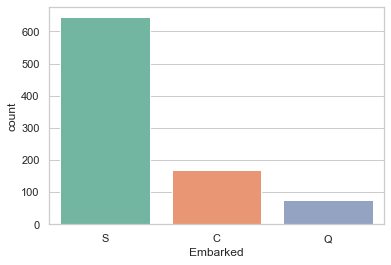

In [12]:
sns.countplot(x='Embarked', data=train, palette='Set2')
plt.show()

**데이터 가공**

Missing Value 치환과정 
- Age: median, 중앙값으로 계산
- Embarked: S, 가장 흔한값이므로 Nan -> S
- Cabin: ignore, Missing Value 가 70퍼센트 이상 존재하기 때문임

In [13]:
train_data = train.copy()

# Missing Value 치환
train_data["Age"].fillna(train["Age"].median(skipna=True), inplace=True)
train_data["Embarked"].fillna(train['Embarked'].value_counts().idxmax(), inplace=True)
train_data.drop('Cabin', axis=1, inplace=True)

In [14]:
# Missing Value 치환된 것을 알 수 있음
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [15]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


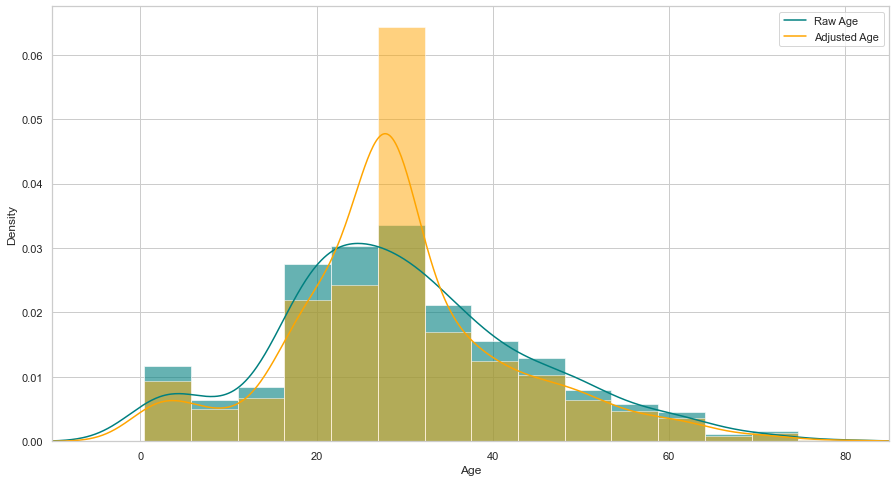

In [16]:
plt.figure(figsize=(15,8))

ax = train["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train["Age"].plot(kind='density', color='teal')

ax = train_data["Age"].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.5)
train_data["Age"].plot(kind='density', color='orange')

ax.legend(['Raw Age', 'Adjusted Age'])
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

**변수 추가**
- TrabelAlone

**수치화**
- Pclass
- Embarked
- Sex

In [17]:
# 혼자 여행하는 사람은 1, 아닌사람은 0으로 설정
train_data['TravelAlone']=np.where((train_data["SibSp"]+train_data["Parch"])>0, 0, 1)

# 이후 Sibsp, Parch 는 다 사용했으므로 버림
train_data.drop('SibSp', axis=1, inplace=True)
train_data.drop('Parch', axis=1, inplace=True)

# 10살 이하는 1, 아닌사람은 0으로 설정
train_data['Child']=np.where((train_data['Age'])>10,0,1)

# Age 다 사용했으므로 버림
train_data.drop('Age', axis=1, inplace=True)

In [18]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Ticket,Fare,Embarked,TravelAlone,Child
0,1,0,3,"Braund, Mr. Owen Harris",male,A/5 21171,7.2500,S,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,71.2833,C,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,7.9250,S,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,53.1000,S,0,0
4,5,0,3,"Allen, Mr. William Henry",male,373450,8.0500,S,1,0


In [19]:
# Pclass, Embarked, Sex 인 값들을 수치화
training = pd.get_dummies(train_data, columns=["Pclass","Embarked","Sex"], drop_first=True)

# 필요없는 자료 버림
training.drop('PassengerId', axis=1, inplace=True)
training.drop('Name', axis=1, inplace=True)
training.drop('Ticket', axis=1, inplace=True)
training.drop('Fare', axis=1, inplace=True)

final_train = training
final_train.head()

,Survived,TravelAlone,Child,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,0,0,0,0,1,0,1,1
1,1,0,0,0,0,0,0,0
2,1,1,0,0,1,0,1,0
3,1,0,0,0,0,0,1,0
4,0,1,0,0,1,0,1,1


**테스트 데이터 적용**

In [20]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

**Age, Fare, Cabin에 Missing Value 존재**

In [21]:
test_data = test.copy()

# Age,Fare Missing Value 치환
test["Age"].fillna(train["Age"].median(skipna=True),inplace=True)
test["Fare"].fillna(train["Fare"].median(skipna=True),inplace=True)

# Cabin은 Missing Value가 많으므로 버림
test_data.drop('Cabin',axis=1,inplace=True)

test_data['TravelAlone']=np.where((test_data["SibSp"]+test_data["Parch"])>0, 0, 1)
test_data['Child']=np.where((test_data["Age"])>10,0,1)

test_data.drop('SibSp', axis=1, inplace=True)
test_data.drop('Parch', axis=1, inplace=True)
test_data.drop('Age', axis=1, inplace=True)

testing = pd.get_dummies(test_data, columns=["Pclass","Embarked","Sex"],drop_first=True)
testing.drop('PassengerId', axis=1, inplace=True)
testing.drop('Name', axis=1, inplace=True)
testing.drop('Ticket', axis=1, inplace=True)
testing.drop('Fare', axis=1, inplace=True)

final_test = testing
final_test.head()

,TravelAlone,Child,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,1,0,0,1,1,0,1
1,0,0,0,1,0,1,0
2,1,0,1,0,1,0,1
3,1,0,0,1,0,1,1
4,0,0,0,1,0,1,0


## Exploratory Data Analysis

**1. Age**

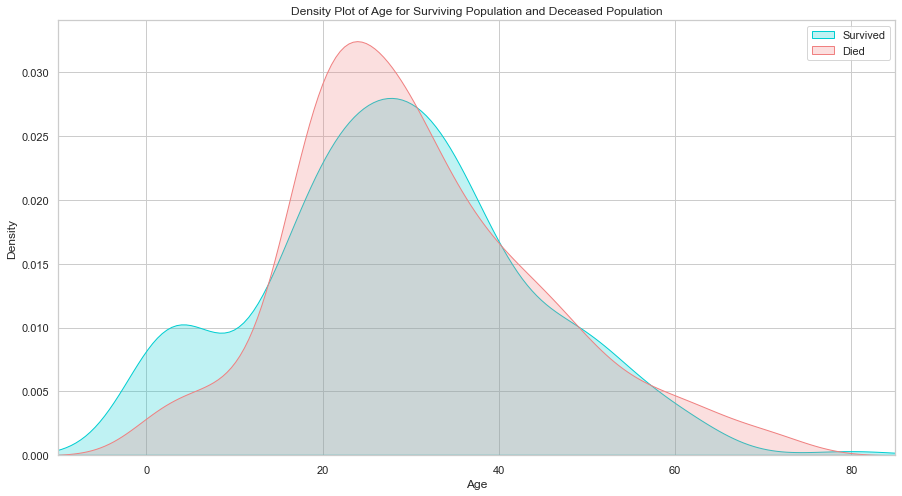

In [22]:
plt.figure(figsize=(15,8))

# Density 확인
ax = sns.kdeplot(train["Age"][final_train.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(train["Age"][final_train.Survived == 0], color="lightcoral", shade=True)

plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

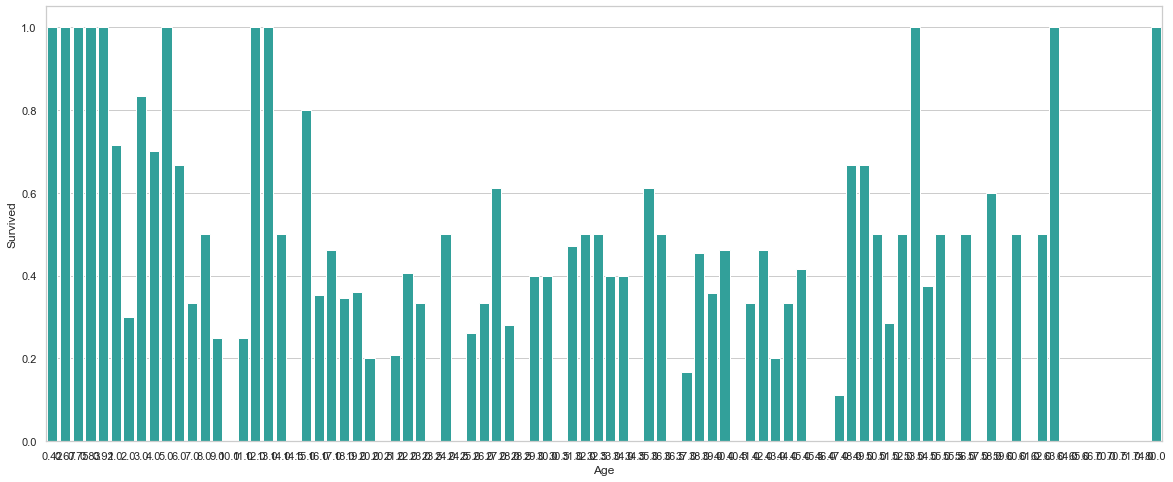

In [23]:
plt.figure(figsize=(20,8))
avg_survival_byage = train[["Age", "Survived"]].groupby(['Age'], as_index=False).mean()
g = sns.barplot(x='Age', y='Survived', data=avg_survival_byage, color="LightSeaGreen")
plt.show()

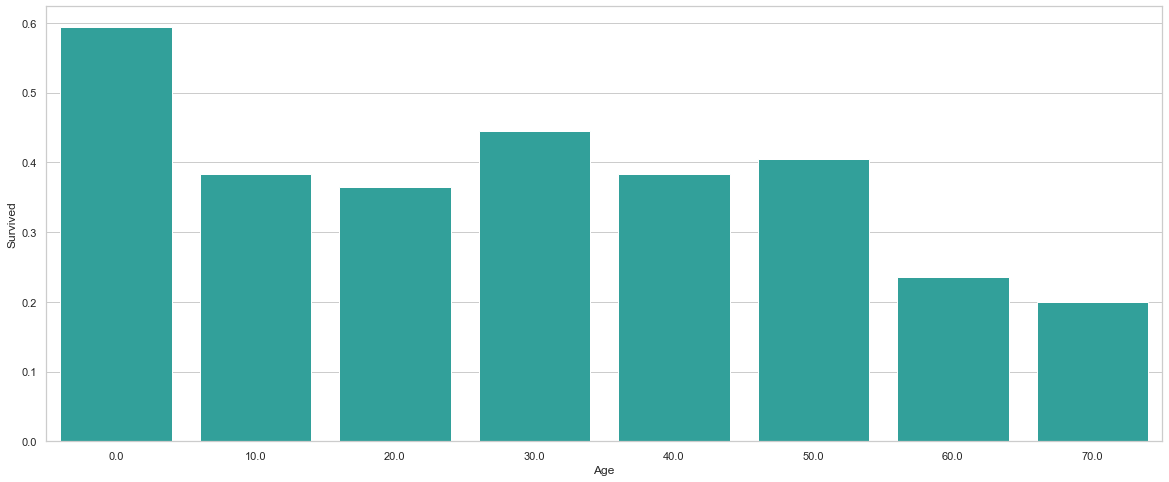

In [24]:
plt.figure(figsize=(20,8))

# 10대, 20대, 30대, ... 생존률 표현
# 80대에서 80살 한명만 존재해서 70대에 넣음
avg_survival_byage = train[["Age", "Survived"]]
avg_survival_byage["Age"] = ((avg_survival_byage["Age"]-0.001)//10)*10
avg_survival_byage = avg_survival_byage.groupby(["Age"],as_index=False).mean()

g = sns.barplot(x='Age', y='Survived', data=avg_survival_byage, color="LightSeaGreen")
plt.show()

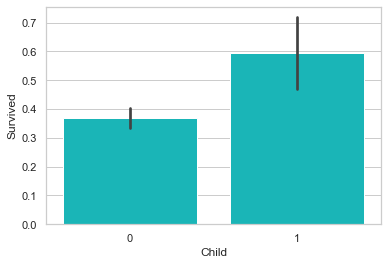

In [25]:
sns.barplot('Child', 'Survived', data=train_data, color="darkturquoise")
plt.show()

**2. Pclass**

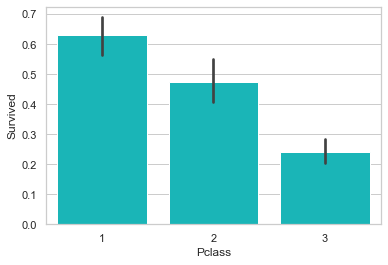

In [26]:
sns.barplot('Pclass', 'Survived', data=train, color="darkturquoise")
plt.show()

**3. Embarked**

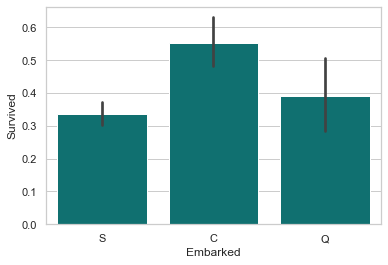

In [27]:
sns.barplot('Embarked', 'Survived', data=train, color="teal")
plt.show()

**5.Travel Alone**

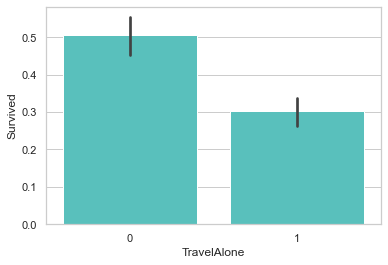

In [28]:
sns.barplot('TravelAlone', 'Survived', data=final_train, color="mediumturquoise")
plt.show()

**6. Sex**

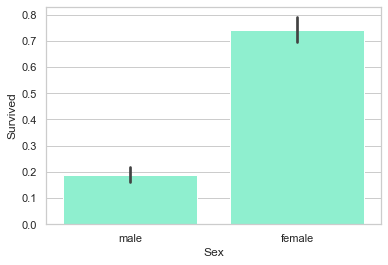

In [29]:
sns.barplot('Sex', 'Survived', data=train, color="aquamarine")
plt.show()

## Feature selection

Unicariate Selection
- F-value를 이용하여 변수선택

Feature Importance
- 불확실도를 낮출수록 값이 커져 그 기준으로 선택

RFE (recursive feature elimination)
- 모든 변수를 우선 다 포함시킨 후 반복해서 학습 진행
- 중요도가 낮은 변수를 하나씩 제거하는 방식

In [30]:
training

,Survived,TravelAlone,Child,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,0,0,0,0,1,0,1,1
1,1,0,0,0,0,0,0,0
2,1,1,0,0,1,0,1,0
3,1,0,0,0,0,0,1,0
4,0,1,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...
886,0,1,0,1,0,0,1,1
887,1,1,0,0,0,0,1,0
888,0,0,0,0,1,0,1,0
889,1,1,0,0,0,0,0,1


In [31]:
testing

,TravelAlone,Child,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,1,0,0,1,1,0,1
1,0,0,0,1,0,1,0
2,1,0,1,0,1,0,1
3,1,0,0,1,0,1,1
4,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...
413,1,1,0,1,0,1,1
414,1,0,0,0,0,0,0
415,1,0,0,1,0,1,1
416,1,1,0,1,0,1,1


In [34]:
from sklearn.linear_model import LogisticRegression

x_train = training.drop('Survived', axis=1)
y_train = training['Survived']

x_test = testing

log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

y_pred = log_reg.predict(x_test)
log_reg.score(x_train, y_train)

0.7991021324354658

In [35]:
from sklearn.feature_selection import RFE
 
X = x_train
y = y_train
# Build a logreg and compute the feature importances
model = LogisticRegression()
# create the RFE model and select 8 attributes
rfe = RFE(model, 7)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))

Selected features: ['TravelAlone', 'Child', 'Pclass_2', 'Pclass_3', 'Embarked_Q', 'Embarked_S', 'Sex_male']


Optimal number of features: 3
Selected features: ['Child', 'Pclass_3', 'Sex_male']


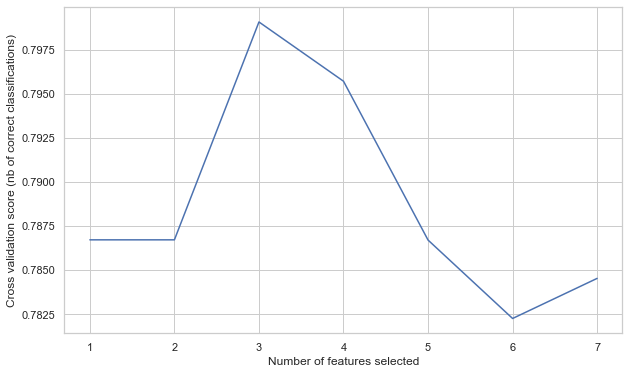

In [36]:
from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

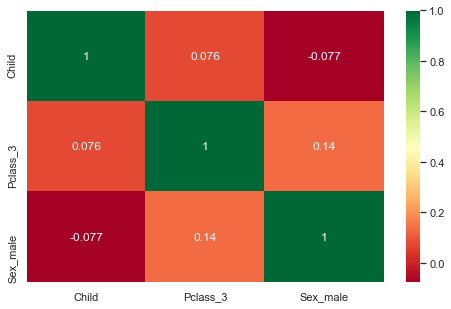

In [37]:
Selected_features=['Child','Pclass_3','Sex_male']
X = x_train[Selected_features]

plt.subplots(figsize=(8, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

In [38]:
y_pred = log_reg.predict(x_test)

In [39]:
submission = pd.DataFrame({
     "PassengerId": test["PassengerId"],
        "Survived": y_pred
})

In [40]:
submission.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0
